In [3]:
%matplotlib inline
%run '../bin/notebook_utils.py'
import matplotlib.ticker as mticker

In [9]:
# Frontera, default MPI
sscaling1_sessions = pd.read_csv('../data/spatial-heterogeneity/sessions.csv', index_col=0)

In [11]:
print('Strong scaling 1: Total number of successful runs: %s' % sscaling1_sessions.shape[0])

Strong scaling 1: Total number of successful runs: 1


In [16]:
# sessions sscaling1
# sscaling1_sids = sorted(['../data/spatial-heterogeneity/sscaling1/'+s for s in sscaling1_sessions.drop_duplicates(['nunit']).index.unique().tolist()])
# sscaling1_sobjs = ra.Experiment(sscaling1_sids, stype='radical.pilot')
sscaling1_sobjs = ra.Experiment(['../data/spatial-heterogeneity/sscaling1/rp.session.login2.frontera.tacc.utexas.edu.mturilli.018320.0001'], stype='radical.pilot')

cache read failed: [Errno 2] No such file or directory: '/Users/mturilli/.radical/analytics/cache//rp.session.login2.frontera.tacc.utexas.edu.mturilli.018320.0001.pickle'
session loaded


In [17]:
metrics_default = [

        # pilot overheads (global)
        ['Pilot Startup',     ['boot', 'setup_1']],
        ['Pilot Termination', ['term' ]],

        # derived pilot durations
        ['Agent Nodes',       ['agent']],
        ['Warmup',            ['warm' ]],
        ['Draining',          ['drain']],
        ['Idle',              ['idle' ]],

        # unit durations (PRTE)
        ['Prepare Execution', ['exec_queue', 'exec_prep']],
        ['Execution RP',      ['exec_rp', 'exec_sh', 'term_sh', 'term_rp']],
        ['Execution Cmd',     ['exec_cmd']],
        ['Unschedule',        ['unschedule']],
]

In [19]:
# choose the metrics we want to use for resource utilization
metrics = metrics_default

# get utilization information
provided_sscaling1, consumed_sscaling1, stats_abs_sscaling1, stats_rel_sscaling1, info_sscaling1 = sscaling1_sobjs.utilization(metrics=metrics)


In [20]:
# x-axis labels
xkeys_sscaling1 = list()

# get the numbers we actually want to plot
for session in sscaling1_sobjs.sessions:

    n_units = len(session.get(etype='unit'))
    
    p_size = 0
    for pilot in session.get(etype='pilot'):
        p_size += pilot.description['cores']

    xkeys_sscaling1.append('%s / %s' % (n_units, p_size))

In [21]:
def update_ticks(x, pos):
    return int(x/4)

TypeError: '>' not supported between instances of 'float' and 'NoneType'

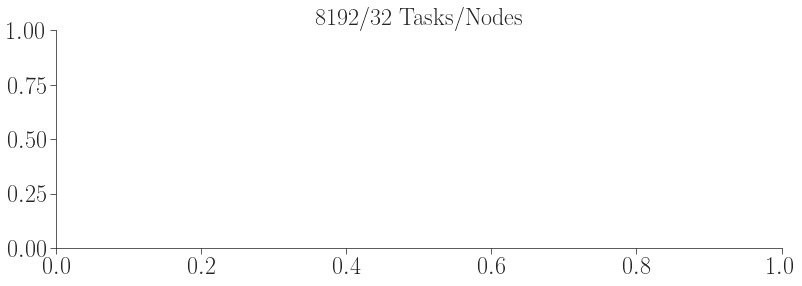

In [26]:
# core utilization over time (box plot)
sid = 'rp.session.login2.frontera.tacc.utexas.edu.mturilli.018320.0001' # 8192 units| 2 nodes
consumed = consumed_sscaling1

fig, ax = fig_setup(figsize=(13,4))

cmap = mpl.cm.get_cmap('tab20c')

step = 1.0 / (len(metrics) + 1)
this = step / 1.0
legend = list()

x_min = None
x_max = None
y_min = None
y_max = None

ax.title.set_text('%s/%s Tasks/Nodes' % ('8192','32'))#(sscaling_sessions.loc[sid].nunit, int(sscaling_sessions.loc[sid].nnode)))

for metric in metrics:

    color = cmap(this)
    this += step

    legend.append(mpl.lines.Line2D([0], [0], color=color, lw=6))

    if isinstance(metric, list):
        name = metric[0]
        parts = metric[1]
    else:
        name = metric
        parts = [metric]

    for part in parts:
        for uid in consumed[sid][part]:
            for block in consumed[sid][part][uid]:
                orig_x = block[0]
                orig_y = block[2] - 0.5
                width = block[1] - block[0]
                height = block[3] - block[2] + 1.0

                if x_min is None:
                    x_min = orig_x
                if x_max is None:
                    x_min = orig_x + width
                if y_min is None:
                    y_min = orig_x
                if y_max is None:
                    y_min = orig_x + height

                x_min = min(x_min, orig_x)
                y_min = min(y_min, orig_y)
                x_max = max(x_max, orig_x + width)
                y_max = max(y_max, orig_y + height)

                patch = mpl.patches.Rectangle((orig_x, orig_y),
                                              width, height,
                                              facecolor=color,
                                              edgecolor='black',
                                              fill=True, lw=0.0)
                ax.add_patch(patch)

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

ax.set_xlabel('Time (s)')
ax.set_ylabel('Core ID')

ax.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

# Add legend
fig.legend(legend, 
       [m[0] for m in metrics], 
       loc='upper center', 
       bbox_to_anchor=(0.5, 1.54),
       fontsize=20,
       ncol=3)

plt.savefig('figures/paper_rp_frontera_strong_scaling_heterogeneous.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/paper_rp_frontera_strong_scaling_heterogeneous.png', dpi=300, bbox_inches='tight')